## Data cleansing

In [1]:
import pandas as pd

In [2]:
user_engagement =pd.read_csv('takehome_user_engagement.csv')

In [3]:
user_engagement.sample(10)

,time_stamp,user_id,visited
68427,2013-11-25 19:32:32,3960,1
80208,2013-05-24 14:18:09,4472,1
59799,2013-12-16 06:11:49,3451,1
137193,2014-02-28 00:44:53,7818,1
177384,2014-01-27 19:47:53,9972,1
92771,2014-03-10 18:36:58,5101,1
205599,2014-01-21 21:50:18,11857,1
160095,2012-11-12 06:46:55,9281,1
109236,2014-04-25 15:38:09,6064,1
87953,2012-11-23 17:50:38,4837,1


## Calculating engagement of a user
A user is considered to be engaged if he/she has logged in at least 3 times in any given week.
In order to do the same, we can extract the date from time_stamp.
The week of the year will be calculated with an assumption that January 1st is the first day of the first week of the year.
The remaining weeks will be accordingly assigned. 

The number of unique visits per week will then be calcuated per user and filtered out for visits greater than 3.

Let's check the datetime field and if it suffices our requirement

In [4]:
user_engagement['time_stamp'].describe()

count                  207917
unique                 207220
top       2014-03-10 21:21:37
freq                        2
Name: time_stamp, dtype: object

The format is that of an object. So in order to obtain the dates, the first task will be to convert them into datetime format.

In [5]:
import datetime as dt
user_engagement['date_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

In [6]:
user_engagement['date_stamp'].dtype

dtype('<M8[ns]')

The datatype is as per the requirement. 

Let's extract the datestamp from it. using the .date() function.

In [7]:
user_engagement['date_stamp'] =user_engagement['date_stamp'].apply(lambda x: x.date())

In [8]:
user_engagement['date_stamp'].describe()

count         207917
unique           736
top       2014-05-21
freq             712
Name: date_stamp, dtype: object

Let's calculate the first date appearing in the dataframe and assume it to be the first date of the first day of inception.

This would ease out calculations in comparison to using 1st Jan as the 1st day of the week.

In [9]:
minimum = user_engagement['date_stamp'].min()
minimum

datetime.date(2012, 5, 31)

31st May 2012 is the first date appearing in the data.

In [10]:
user_engagement['date_stamp'].max()

datetime.date(2014, 6, 6)

Let's now assign week numbers to all the dates.

In [11]:
user_engagement['week'] = user_engagement['date_stamp'].apply(lambda a: ((a-minimum) /7). days +1 )

In [12]:
user_engagement['week'].describe()

count    207917.000000
mean         74.384490
std          23.088945
min           1.000000
25%          59.000000
50%          79.000000
75%          94.000000
max         106.000000
Name: week, dtype: float64

We have weeks from 1 to 106.

742 days are covered and that is inline with the minimum and maximum dates we observed.

Now let's calculate the visits of each of the users per week.

Since we need unique visits only, let's drop the multiple entries of each user per day.

In [13]:
user_engagement.drop_duplicates(['user_id', 'date_stamp'], inplace =True)

In [14]:
user_engagement.shape

(207917, 5)

The number of rows stays the same, implying there were no duplicate entries any given day.

Let's now calculate the number of visits by a user per week.

In [15]:
visits = user_engagement.groupby(['user_id', 'week']).sum('visits')

In [16]:
visits

visited
user_id week         
1       99          1
2       77          1
        79          1
        80          1
        82          1
...               ...
11996   67          1
11997   33          1
11998   100         1
11999   1           1
12000   87          1

[68445 rows x 1 columns]

In [17]:
user_visits_per_week =pd.merge(user_engagement, visits, how ='left', on= 'user_id') [['user_id' , 'visited_y']]

In [18]:
user_visits_per_week.sample(10)

,user_id,visited_y
2151275,2193,4
7110783,6284,2
26441,42,6
9469245,8701,6
1951003,2011,2
7036148,6204,7
9164335,8310,7
12687048,11688,7
7212329,6370,5
10844009,9691,7


In [19]:
user_visits_meeting_threshold = user_visits_per_week[user_visits_per_week['visited_y']>2].drop_duplicates('user_id').drop(['visited_y'], axis=1)

In [20]:
user_visits_meeting_threshold.sample(10)

,user_id
3606934,3405
6627351,5806
2930271,2744
5049852,4494
7295132,6416
11923431,10785
9549956,8749
6628009,5828
10313746,9383
11250068,10118


In [21]:
user_visits_meeting_threshold['engaged']=1

Now let's merge this with the details of the users.

In [22]:
users= pd.read_csv('takehome_users.csv',encoding='latin1')

In [23]:
users.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


In [24]:
users.rename(columns = {'object_id': 'user_id'}, inplace =True)

In [25]:
users.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [33]:
merged = pd.merge(users,user_visits_meeting_threshold , how ='left' , on ='user_id')

In [34]:
merged.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,NaN
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0


In [35]:
merged['creation_time'] = pd.to_datetime(merged['creation_time'])
merged['creation_date'] = merged['creation_time'].apply(lambda x: x.date())

In [36]:
merged['creation_date'].describe()

count          12000
unique           730
top       2014-05-30
freq              71
Name: creation_date, dtype: object

In [37]:
merged['engaged'].fillna(0, inplace =True)
merged['engaged'].unique()

array([0., 1.])

In [38]:
merged[pd.isna(merged['name'])]

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged,creation_date


In [39]:
merged[pd.isna(merged['email'])]

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged,creation_date


In [40]:
merged['invited'] =0
merged.loc[~pd.isna(merged['invited_by_user_id']), 'invited']=1

In [41]:
merged['invited'].value_counts()

1    6417
0    5583
Name: invited, dtype: int64

In [42]:
merged.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'engaged',
       'creation_date', 'invited'],
      dtype='object')

We can use the fields creation_date, invited, last_session_creation_time, opted_in_to_mailing_list and creation_source to identify how the customers are engaging.

In [43]:
merged.to_csv('final.csv', index =False)

In [44]:
merged.corr()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged,invited
user_id,1.000000,0.015238,-0.032370,-0.022040,0.004110,0.018699,0.007663,-0.009149
last_session_creation_time,0.015238,1.000000,0.006590,0.008035,0.042203,0.011874,0.401413,0.004916
opted_in_to_mailing_list,-0.032370,0.006590,1.000000,0.483529,0.003432,0.004699,0.005013,0.006934
enabled_for_marketing_drip,-0.022040,0.008035,0.483529,1.000000,0.009275,0.003687,0.002309,0.002216
org_id,0.004110,0.042203,0.003432,0.009275,1.000000,-0.057780,0.062970,-0.018442
invited_by_user_id,0.018699,0.011874,0.004699,0.003687,-0.057780,1.000000,0.002021,NaN
engaged,0.007663,0.401413,0.005013,0.002309,0.062970,0.002021,1.000000,0.025815
invited,-0.009149,0.004916,0.006934,0.002216,-0.018442,NaN,0.025815,1.000000


The last session creation seems to be having a positive correlation with the engagement of the customer.
Let's also include the number of days on books and find how it is related.

In [45]:
print(merged['creation_date'].min())
print(merged['creation_date'].max())


2012-05-31
2014-05-30


Let's assume that the data was extracted on 31st May 2014 for simplicity.
Using 31st May 2014 as the latest date, the Months on Books can be calculated.

In [46]:
merged['MOB'] = merged['creation_date'].apply(lambda x: (merged['creation_date'].max() - x).days +1)

In [47]:
merged['MOB'].value_counts()

1      71
2      49
3      45
10     42
4      41
       ..
599     6
335     5
726     5
463     5
341     4
Name: MOB, Length: 730, dtype: int64

In [48]:
merged.corr()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged,invited,MOB
user_id,1.000000,0.015238,-0.032370,-0.022040,0.004110,0.018699,0.007663,-0.009149,-0.011005
last_session_creation_time,0.015238,1.000000,0.006590,0.008035,0.042203,0.011874,0.401413,0.004916,-0.788171
opted_in_to_mailing_list,-0.032370,0.006590,1.000000,0.483529,0.003432,0.004699,0.005013,0.006934,0.007304
enabled_for_marketing_drip,-0.022040,0.008035,0.483529,1.000000,0.009275,0.003687,0.002309,0.002216,-0.005142
org_id,0.004110,0.042203,0.003432,0.009275,1.000000,-0.057780,0.062970,-0.018442,-0.004739
invited_by_user_id,0.018699,0.011874,0.004699,0.003687,-0.057780,1.000000,0.002021,NaN,-0.016842
engaged,0.007663,0.401413,0.005013,0.002309,0.062970,0.002021,1.000000,0.025815,0.099924
invited,-0.009149,0.004916,0.006934,0.002216,-0.018442,NaN,0.025815,1.000000,-0.005307
MOB,-0.011005,-0.788171,0.007304,-0.005142,-0.004739,-0.016842,0.099924,-0.005307,1.000000


In order to build a model for prediction, let's look at the features to be engineered.

In [49]:
merged.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged,creation_date,invited,MOB
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,2014-04-22,1,39
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0,2013-11-15,1,197
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,2013-03-19,1,438
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,2013-05-21,1,375
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,2013-01-17,1,499
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0.0,2013-12-17,1,165
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0.0,2012-12-16,0,531
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0.0,2013-07-31,0,304
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0.0,2013-11-05,0,207
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0,2013-01-16,1,500


We can drop the fields creation_time, name, email, user_id, org_id

In [50]:
#'creation_time', 'name', 'email', 'user_id', 'org_id', 

merged.drop(['invited_by_user_id', 'creation_date'], axis =1, inplace =True)

In [51]:
merged.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,invited,MOB
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,0.0,1,39
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,0.0,1,197
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,0.0,1,438
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,0.0,1,375
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,0.0,1,499
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,0.0,1,165
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,0,531
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0.0,0,304
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0.0,0,207
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,1.0,1,500


In [52]:
creation_source = pd.get_dummies(merged['creation_source'])

In [53]:
creation_source.head(10)

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,0,0,0,1,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,1,0,0,0


In [54]:
concatenated = pd.concat([merged.drop('creation_source', axis=1),creation_source], axis =1)

In [55]:
concatenated.head(10)

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,invited,MOB,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,0.0,1,39,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,0.0,1,197,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,0.0,1,438,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,0.0,1,375,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,0.0,1,499,1,0,0,0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,1.387424e+09,0,0,197,0.0,1,165,1,0,0,0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,1.356010e+09,0,1,37,0.0,0,531,0,0,0,1,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,NaN,1,1,74,0.0,0,304,0,0,1,0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,NaN,0,0,302,0.0,0,207,0,0,1,0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,1.401833e+09,1,1,318,1.0,1,500,0,1,0,0,0


In [56]:
concatenated['last_session_creation_time'].fillna(0, inplace=True)

In [57]:
concatenated.sample(10)

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,invited,MOB,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
8105,8106,2012-11-16 01:08:05,Roper Aaron,AaronRoper@gmail.com,1.353374e+09,0,1,200,0.0,1,561,0,1,0,0,0
6180,6181,2013-12-18 09:30:50,Begum Jordan,JordanBegum@gmail.com,0.000000e+00,1,0,397,0.0,0,164,0,0,1,0,0
8413,8414,2014-01-08 08:30:42,Martins Emily,EmilyCavalcantiMartins@gmail.com,1.389343e+09,0,0,238,0.0,0,143,0,0,0,0,1
2633,2634,2014-03-21 16:49:37,Hoddle Zara,ZaraHoddle@gustr.com,1.395593e+09,0,0,35,0.0,1,71,1,0,0,0,0
1624,1625,2013-10-27 13:04:37,Summers Isabella,IsabellaSummers@cuvox.de,0.000000e+00,0,0,85,0.0,1,216,0,1,0,0,0
2193,2194,2014-05-07 20:04:20,Knight Bethany,BethanyKnight@gmail.com,1.401912e+09,1,0,135,0.0,0,24,0,0,0,0,1
2950,2951,2013-12-12 06:15:39,Dias Letícia,LeticiaRibeiroDias@hotmail.com,1.386829e+09,1,0,100,0.0,1,170,1,0,0,0,0
8720,8721,2012-09-10 20:00:15,Gottlieb Kathrin,wpiwhxql@igiwm.com,1.400962e+09,0,0,76,1.0,1,628,0,1,0,0,0
5875,5876,2014-01-14 18:35:10,Eriksen Anton,AntonEEriksen@yahoo.com,0.000000e+00,1,1,5,0.0,0,137,0,0,0,1,0
10071,10072,2013-11-28 01:42:24,Jackson Samuel,SamuelJackson@hotmail.com,1.385603e+09,1,1,9,0.0,1,184,0,1,0,0,0


<AxesSubplot:>

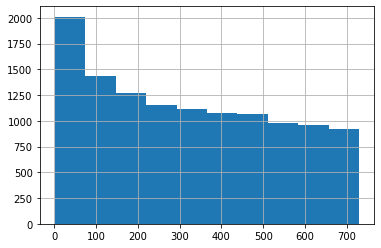

In [59]:
concatenated['MOB'].hist()

We can see that there is an even distribution across all MOBs.
Let's create 8 bins with 100 days in a bin.

In [60]:
def MOB_bin(MOB):
    if MOB <100:
        MOB_bin = '0_100_days'
    elif MOB <200:
        MOB_bin = '100_200_days'
    elif MOB <300:
        MOB_bin = '200_300_days'
    elif MOB <400:
        MOB_bin = '300_400_days'
    elif MOB <500:
        MOB_bin = '400_500_days'
    elif MOB <600:
        MOB_bin = '500_600_days'
    elif MOB <700:
        MOB_bin = '600_700_days'
    else:
        MOB_bin ='Over_700_days'
    return MOB_bin

In [61]:
concatenated['MOB_bin'] = concatenated['MOB'].apply(lambda x: MOB_bin(x))

In [62]:
concatenated.head(10)

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,invited,MOB,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,MOB_bin
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,0.0,1,39,1,0,0,0,0,0_100_days
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,0.0,1,197,0,1,0,0,0,100_200_days
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,0.0,1,438,0,1,0,0,0,400_500_days
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,0.0,1,375,1,0,0,0,0,300_400_days
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,0.0,1,499,1,0,0,0,0,400_500_days
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,1.387424e+09,0,0,197,0.0,1,165,1,0,0,0,0,100_200_days
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,1.356010e+09,0,1,37,0.0,0,531,0,0,0,1,0,500_600_days
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,0.000000e+00,1,1,74,0.0,0,304,0,0,1,0,0,300_400_days
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,0.000000e+00,0,0,302,0.0,0,207,0,0,1,0,0,200_300_days
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,1.401833e+09,1,1,318,1.0,1,500,0,1,0,0,0,500_600_days


In [63]:
MOB = pd.get_dummies(concatenated['MOB_bin'])

In [73]:
concatenated_mob =pd.concat([concatenated.drop(['MOB', 'MOB_bin'], axis=1), MOB], axis=1)

In [74]:
#Due to formatting and interpretation issues, dropping the last session creation time
concatenated_mob.drop(['last_session_creation_time', 'user_id',  'creation_time', 'name','email', 'org_id'], axis=1, inplace =True)


## Modeling 

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Choosing Random Forest regression in order to avoid any over fitting and also to aid feature selection process.

In [76]:
X_train,X_test, y_train, y_test = train_test_split(concatenated_mob.drop(['engaged'], axis=1), concatenated_mob['engaged'], test_size =0.3)

In [77]:
estimators = [10,50,100,200]
features =[2,5,7,10]
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid= {'n_estimators': estimators, 'max_features': features},cv =5, scoring= 'roc_auc')

In [78]:
X_train.head(10)

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,0_100_days,100_200_days,200_300_days,300_400_days,400_500_days,500_600_days,600_700_days,Over_700_days
4434,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2496,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3185,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1520,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
8215,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
642,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
7301,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3207,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
7055,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3270,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [79]:
grid_trained_model = grid.fit(X_train,y_train)

In [80]:
print(grid_trained_model.best_params_,grid_trained_model.best_score_)

{'max_features': 10, 'n_estimators': 50} 0.6070615889317567


In [81]:
best_model = RandomForestClassifier(n_estimators=100, max_features=10)

In [82]:
model = best_model.fit(X_train, y_train)

In [83]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [84]:
accuracy_score(model.predict(X_test),y_test)

0.875

In [85]:
precision_score(model.predict(X_test),y_test)

0.002232142857142857

In [86]:
recall_score(model.predict(X_test),y_test)

0.25

In [100]:
confusion_matrix(model.predict(X_test),y_test)

array([[3149,  447],
       [   3,    1]], dtype=int64)

The model has imbalanced negative outcomes. Hence getting low precision and recall scores.

In [101]:
# To select the best features
imp = pd.Series(model.feature_importances_, index=X_test.columns)
imp = imp.sort_values(ascending=False)
print(imp)

0_100_days                    0.237053
enabled_for_marketing_drip    0.132514
opted_in_to_mailing_list      0.126155
PERSONAL_PROJECTS             0.078635
500_600_days                  0.049721
100_200_days                  0.046011
600_700_days                  0.042150
400_500_days                  0.039715
SIGNUP_GOOGLE_AUTH            0.036150
200_300_days                  0.035834
300_400_days                  0.035822
Over_700_days                 0.033472
GUEST_INVITE                  0.031658
ORG_INVITE                    0.029395
SIGNUP                        0.028258
invited                       0.017457
dtype: float64


It can be seen that customers who have signed up recently are more likely to be engaged.
it is also seen that the ones who have enabled for marketing drip and opted for mailing list have a higher engagement.
So it is clear that higher the interaction of the company with the customers, higher is their likelihood to be engaged with the facility.